<a href="https://colab.research.google.com/github/ronykroy/DNN-NLP-and-other-stuff/blob/master/Bert_pytorch_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Source # https://mccormickml.com/2019/07/22/BERT-fine-tuning/
# https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO

TODO:
The default version of TensorFlow in Colab will soon switch to TensorFlow 2.x.
We recommend you upgrade now or ensure your notebook will continue to use TensorFlow 1.x via the %tensorflow_version 1.x magic: more info.  
Using: for now  
%tensorflow_version 1.x  
import tensorflow as tf  
https://colab.research.google.com/notebooks/tensorflow_version.ipynb#scrollTo=NCEP-DG0VxlV  
1) Use this later to see where the old code breaks  
%tensorflow_version 2.x  
2) use imdb.. get it in the format expected by bert.. for now use cola ds  
3) then go for news groups ds  

In [36]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [37]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io, os , re
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0) 
# get device name.. as device.. to move to gpu later on

'Tesla K80'

https://github.com/bentrevett/pytorch-sentiment-analysis  
Other ways of doing it in pure pytorch...   
A little dated

In [0]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f: # modificaitons for tf2 gfile moved to io
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True) # sample fact 1/100% idiomatic way to shuffle

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  # return 1/10 th of 50k rows.. becaus this is bert.. should be enough
  return pd.concat([train_df, test_df]).sample(frac=0.1).reset_index(drop=True) # same as that in emlo classifer except we have this concat-ed


In [41]:
# Reduce logging output.
#tf.logging.set_verbosity(tf.logging.ERROR)
# https://github.com/tensorflow/tensorflow/issues/26662
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


df = download_and_load_datasets()
df.head()

,sentence,sentiment,polarity
0,Bring Back The A-team was a hour- long special...,9,1
1,The premise of the film was very promising - s...,2,0
2,Watching this movie made me think constantly; ...,1,0
3,Many questions arise about the making of this ...,2,0
4,It is said that David Lynch's films and shorts...,7,1


In [42]:
df.shape

(5000, 3)

In [43]:
df.polarity.value_counts() # close enuf to be evenly distributed

0    2517
1    2483
Name: polarity, dtype: int64

In [0]:
 df, df_test = train_test_split(df, stratify = df['polarity'], test_size = 0.15, random_state = 11)

In [0]:
# Create sentence and label lists
sentences = df.sentence.values

In [0]:

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences] # cls -> class , sep -> separator
labels = df.polarity.values # in imdb this sentence column may not necessarily have a sentence.. it can have more than 1

In [47]:
# the tokenization step
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'hawke', '##d', 'as', 'the', 'most', 'offensive', 'movie', 'ever', ',', 'guaranteed', 'to', 'off', '##end', 'everyone', '-', 'guess', 'what', '?', 'it', 'worked', ',', 'i', "'", 'm', 'offended', 'that', 'we', 'shell', '##ed', 'out', 'money', 'to', 'rent', 'this', '.', 'two', 'friends', 'and', 'i', 'were', 'bored', 'and', 'decided', 'to', 'see', 'if', 'all', 'that', 'bull', 'about', 'the', 'movie', 'that', 'we', 'saw', 'on', 'tv', 'was', 'true', '.', 'curse', 'comedy', 'central', 'and', 'all', 'the', 'other', 'networks', 'that', 'pushed', 'this', 'garbage', 'on', 'us', '!', 'it', 'was', 'by', 'far', 'the', 'worst', 'movie', 'i', "'", 've', 'seen', 'since', 'hollow', 'man', '.', 'i', 'generally', 'avoid', 'the', 'crap', '##py', 'ones', ',', 'but', 'got', 'sucked', 'into', 'this', 'one', '.', 'we', 'have', 'since', 'beaten', 'the', 'prick', 'who', 'suggest', 'we', 'rent', 'it', ',', 'and', 'his', 'movie', 'picking', 'privileges', 'have', 'been', 'rev

In [0]:
MAX_LEN = 128 
# good practice to check what is your longest sentence.. in your training corpus
# also check that the longest sentence is not an outlier..
# if it is.. then settle for some 90-80th %lie length of the sentence lengths distribution

In [49]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (615 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (525 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1015 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (866 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (561 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length 

In [0]:
#Sequence len for a lot of them is > 512
# how to deal with it 
# https://github.com/huggingface/transformers/issues/89
# sliding window approach
# https://github.com/huggingface/transformers/issues/89

# TODO: check how the sliding window is done in run_squad.py
# for now keep going till the code breaks...
# might lead to a much lesser accuracy than whats observed with cola task
# cola had one sentence.. per line.. and check if its grammatically coorect or not
# alter native approach..

# tfidf tokenizer.. top 512 words..?
# ditch the cls and sep tokens..?

In [0]:
# https://towardsdatascience.com/bert-to-the-rescue-17671379687f
# truncation works too... 

# set max to 800 or arbit long ones.. in the args
#https://github.com/nlpyang/PreSumm/issues/7

In [0]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# the irony :)
# sequence for a lot of them is > 512 and then we pad the rest..  :p
# from keras pre processing

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

>**input ids:** a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary  
**segment mask:** (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence  
**attention mask:** (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 
**labels(the target):** a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical" < so basically we are training a gammar nazi :)

### A walkthrough of how we got to attention masks array/list

In [54]:
sentences[1]

"[CLS] LES CONVOYEURS ATTENDENT was the first film I saw in 2000 and I doubt I'll see a better one this year. This beautiful tragicomedy by Belgian filmmaker Benoît Mariage is set in the industrial wastelands of Wallonia. Benoît Poelvoorde plays a father who desperately wants his son to win a car (a Lada!) for him. To do this the son has to break the record opening doors. What the father actually wants his for his son to be someone, because he himself has never made it further as the reporter of local news for a newspaper ironically called L'Espoir (Hope). Of course nothing works out as planned. This film can best be compared to Aki Kaurismäki's DRIFTING CLOUDS, although it is more dramatic and the humour is darker. Just like in that film however the tone is more melancholic than depressing and the ending upbeat, without being unrealistically happy. The humour is absurd, without making the plot unbelievable, and Mariage finds stunning images in the bleak settings that never seem artifi

In [55]:
print(tokenized_texts[1])

['[CLS]', 'les', 'convoy', '##eurs', 'attend', '##ent', 'was', 'the', 'first', 'film', 'i', 'saw', 'in', '2000', 'and', 'i', 'doubt', 'i', "'", 'll', 'see', 'a', 'better', 'one', 'this', 'year', '.', 'this', 'beautiful', 'tragic', '##ome', '##dy', 'by', 'belgian', 'filmmaker', 'benoit', 'maria', '##ge', 'is', 'set', 'in', 'the', 'industrial', 'waste', '##lands', 'of', 'wall', '##onia', '.', 'benoit', 'poe', '##l', '##vo', '##ord', '##e', 'plays', 'a', 'father', 'who', 'desperately', 'wants', 'his', 'son', 'to', 'win', 'a', 'car', '(', 'a', 'lad', '##a', '!', ')', 'for', 'him', '.', 'to', 'do', 'this', 'the', 'son', 'has', 'to', 'break', 'the', 'record', 'opening', 'doors', '.', 'what', 'the', 'father', 'actually', 'wants', 'his', 'for', 'his', 'son', 'to', 'be', 'someone', ',', 'because', 'he', 'himself', 'has', 'never', 'made', 'it', 'further', 'as', 'the', 'reporter', 'of', 'local', 'news', 'for', 'a', 'newspaper', 'ironically', 'called', 'l', "'", 'es', '##po', '##ir', '(', 'hope', 

In [56]:
print(input_ids[1]) # @ this place its already padded to max length

[  101  4649  9549 26744  5463  4765  2001  1996  2034  2143  1045  2387
  1999  2456  1998  1045  4797  1045  1005  2222  2156  1037  2488  2028
  2023  2095  1012  2023  3376 13800  8462  5149  2011  6995 12127 21721
  3814  3351  2003  2275  1999  1996  3919  5949  8653  1997  2813 12488
  1012 21721 18922  2140  6767  8551  2063  3248  1037  2269  2040  9652
  4122  2010  2365  2000  2663  1037  2482  1006  1037 14804  2050   999
  1007  2005  2032  1012  2000  2079  2023  1996  2365  2038  2000  3338
  1996  2501  3098  4303  1012  2054  1996  2269  2941  4122  2010  2005
  2010  2365  2000  2022  2619  1010  2138  2002  2370  2038  2196  2081
  2009  2582  2004  1996  6398  1997  2334  2739  2005  1037  3780 18527
  2170  1048  1005  9686  6873  4313  1006  3246]


In [57]:
len(input_ids[1])

128

In [58]:
len(attention_masks[1])

128

In [59]:
print(attention_masks[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, # y bother with input ids here then..?
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [63]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [65]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [67]:
%%time
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5449299849569798


Epoch:  25%|██▌       | 1/4 [03:15<09:46, 195.56s/it]

Validation Accuracy: 0.7584325396825397
Train loss: 0.301793000412484


Epoch:  50%|█████     | 2/4 [06:30<06:30, 195.33s/it]

Validation Accuracy: 0.8090277777777778
Train loss: 0.13314307521407803


Epoch:  75%|███████▌  | 3/4 [09:45<03:15, 195.37s/it]

Validation Accuracy: 0.8291170634920635
Train loss: 0.042532888264395295


Epoch: 100%|██████████| 4/4 [13:00<00:00, 195.30s/it]

Validation Accuracy: 0.8246527777777778


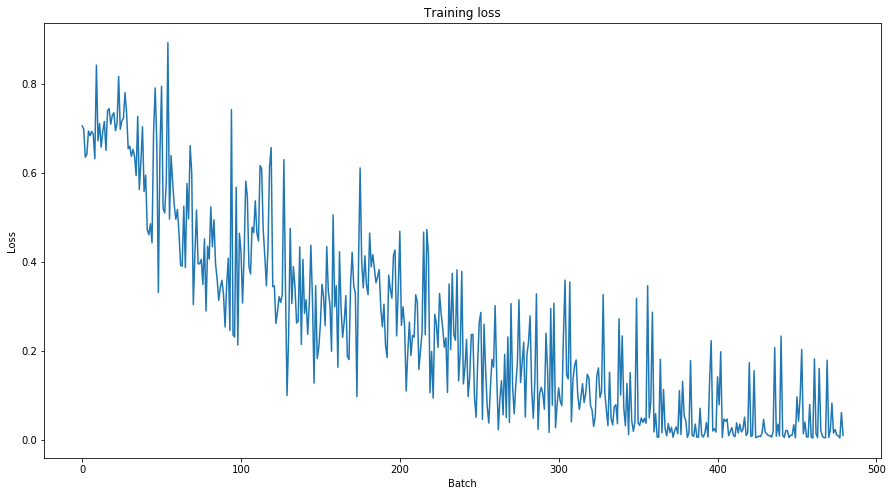

In [68]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [0]:
# predicitonon hold out set
df = df_test

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.polarity.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [72]:
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (567 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (517 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (638 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (706 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (895 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length f

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [76]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.6583833531400161

In [77]:
print(flat_predictions)

[0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1
 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 1
 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1
 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0
 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0
 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0
 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0
 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0
 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0
 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0
 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1
 1 0 1 0 0 1 0 0 1 0 1 1 

In [78]:
print(flat_true_labels)

[1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 

In [0]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [80]:
results = confusion_matrix(flat_true_labels, flat_predictions) 
print ('Confusion Matrix :')
print(results) 

Confusion Matrix :
[[337  41]
 [ 89 283]]


In [81]:
pd.DataFrame(results) #neater

,0,1
0,337,41
1,89,283


In [82]:
print ('Accuracy Score :',accuracy_score(flat_true_labels, flat_predictions) )

Accuracy Score : 0.8266666666666667


In [83]:
print ('Report : ')
print (classification_report(flat_true_labels, flat_predictions) )

Report : 
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       378
           1       0.87      0.76      0.81       372

    accuracy                           0.83       750
   macro avg       0.83      0.83      0.83       750
weighted avg       0.83      0.83      0.83       750

